In [1]:
import pandas as pd
import yaml
import numpy as np

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 100)

from typing import List, Tuple
import matplotlib.pyplot as plt
import networkx as nx

from networkx import write_gpickle
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

from causal_discovery import causal_discovery
from utils import plot_graph

# Load Data

In [2]:
METADATA_PATH = "cub_dataset_metadata.csv"
cub_metadata_df = pd.read_csv(METADATA_PATH, index_col="image_id")

ALL_CONCEPTS = [
    "is_bill_shape_all-purpose",
    "is_wing_color_black",
    "is_upperparts_color_black",
    "is_underparts_color_white",
    "is_breast_pattern_solid",
    "is_back_color_black",
    "is_tail_shape_notched_tail",
    "is_upper_tail_color_black",
    "is_head_pattern_plain",
    "is_breast_color_white",
    "is_throat_color_white",
    "is_eye_color_black",
    "is_bill_length_shorter_than_head",
    "is_forehead_color_black",
    "is_under_tail_color_black",
    "is_nape_color_black",
    "is_belly_color_white",
    "is_wing_shape_rounded-wings",
    "is_size_small_(5_-_9_in)",
    "is_shape_perching-like",
    "is_back_pattern_solid",
    "is_tail_pattern_solid",
    "is_belly_pattern_solid",
    "is_primary_color_black",
    "is_leg_color_grey",
    "is_bill_color_black",
    "is_crown_color_black",
    "is_wing_pattern_multi-colored",
]

df_train = cub_metadata_df[cub_metadata_df["train_val_test"] == "train"]

In [3]:
from sklearn.metrics import roc_auc_score
import numpy as np

concept_compatibility_w_score = pd.Series(index=ALL_CONCEPTS)
for concept in ALL_CONCEPTS:
    concept_compatibility_w_score[concept] = np.abs(
        roc_auc_score(df_train[concept], df_train["is_Warbler_score"]) - 0.5
    )

/mnt/home/ricardo.moreira/concept-based-explanations/concept_weasul_condapack/lib/python3.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [4]:
N_CONCEPTS = 7
SOFT_LABELS = False

CONCEPTS = concept_compatibility_w_score.sort_values(ascending=False)[:N_CONCEPTS].index.tolist()

In [5]:
for c in CONCEPTS:
    print(f' - "{c}"')

 - "is_shape_perching-like"
 - "is_bill_length_shorter_than_head"
 - "is_bill_shape_all-purpose"
 - "is_eye_color_black"
 - "is_nape_color_black"
 - "is_primary_color_black"
 - "is_back_color_black"


In [6]:
vars_for_causal_discovery = [f"{v}_soft" if SOFT_LABELS else v for v in CONCEPTS] + [
    "is_Warbler_score"
]

# Causal Discovery with NO TEARS

In [7]:
df_train[vars_for_causal_discovery]

,is_shape_perching-like,is_bill_length_shorter_than_head,is_bill_shape_all-purpose,is_eye_color_black,is_nape_color_black,is_primary_color_black,is_back_color_black,is_Warbler_score
image_id,,,,,,,,
2,1,1,0,1,0,0,0,0.000664
4,0,0,0,1,0,0,0,0.001955
5,0,0,0,0,1,1,0,0.002244
7,0,0,0,1,0,0,0,0.011471
9,0,0,0,1,0,0,0,0.014400
...,...,...,...,...,...,...,...,...
11776,0,1,1,1,0,0,0,0.224593
11778,1,1,1,0,1,0,0,0.115614
11781,0,0,0,1,0,0,0,0.203121


In [8]:
notears_graph = causal_discovery(
    df_train[vars_for_causal_discovery],
    method="NO TEARS",
    max_iter=100,
    h_tol=1e-8,
)

Doing causal discovery with method: NO TEARS.


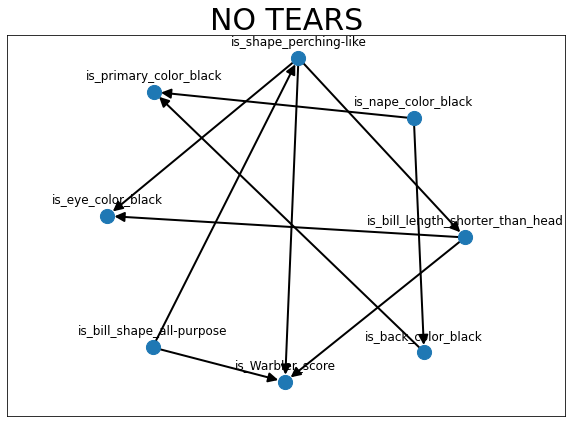

In [15]:
notears_graph_updated = notears_graph.copy()
notears_graph_updated.remove_edges_below_threshold(0.25)

plot_graph(notears_graph_updated, node_size=200, figsize=(10, 7))
plt.title("NO TEARS", fontsize=30)
plt.show()

In [13]:
nx.is_directed_acyclic_graph(notears_graph_updated)

True

In [14]:
len(notears_graph_updated.edges)

10

In [15]:
NOTEARS_GRAPH_PATH = "causal_graphs/CUB_concept_graph_NO_TEARS.pkl"
write_gpickle(notears_graph_updated, NOTEARS_GRAPH_PATH)

# Causal Discovery with PC alg

In [16]:
pc_graph = causal_discovery(
    df_train[vars_for_causal_discovery],
    method="PC",
    alpha=0.3,
    indep_test="fisherz",
    stable=True,
)

Doing causal discovery with method: PC.


  0%|          | 0/8 [00:00<?, ?it/s]

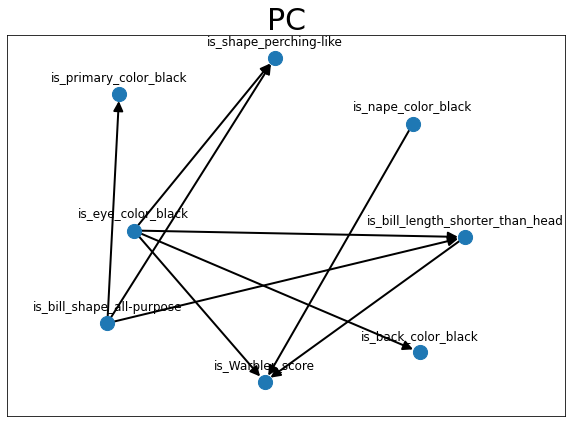

In [19]:
plot_graph(pc_graph, node_size=200, figsize=(10, 7))
plt.title("PC", fontsize=30)
plt.show()

In [20]:
nx.is_directed_acyclic_graph(pc_graph)

True

In [21]:
len(pc_graph.edges)

9

In [65]:
PC_GRAPH_PATH = "causal_graphs/CUB_concept_graph_PC.pkl"
write_gpickle(pc_graph, PC_GRAPH_PATH)

# Causal Discovery with GES

In [23]:
ges_graph = causal_discovery(
    df_train[vars_for_causal_discovery], method="GES", score_func="local_score_BIC"
)

Doing causal discovery with method: GES.
[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  0  0  0  0]]
[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  1  0 -1  0]
 [ 0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  0  0  0  0]]
[[ 0 -1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 -1  0  0]
 [ 0  0  0  0 -1  0 -1  0]
 [ 0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  0  0  0  0]]
[[ 0 -1  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 -1 -1  0]
 [ 0  0  0  0 -1  0 -1  0]
 [ 0  0  0  0  1 -1  0  0]
 [ 0  0  0  0  0  0  0  0]]
[[ 0 -1  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1]
 [ 0  0  0

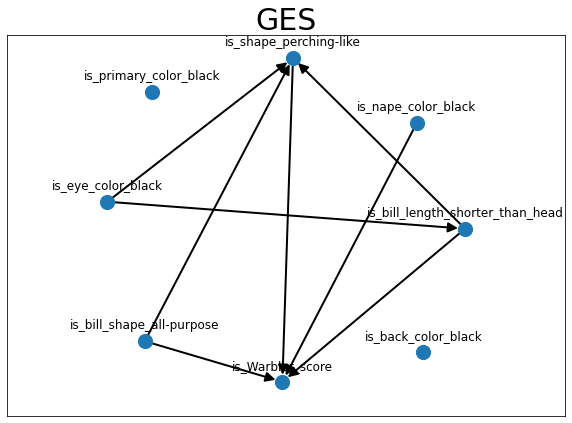

In [29]:
plot_graph(ges_graph, node_size=200, figsize=(10, 7))
plt.title("GES", fontsize=30)
plt.show()

In [25]:
nx.is_directed_acyclic_graph(ges_graph)

True

In [26]:
len(ges_graph.edges)

8

In [79]:
GES_GRAPH_PATH = "causal_graphs/CUB_concept_graph_GES.pkl"
write_gpickle(ges_graph, GES_GRAPH_PATH)

# Causal Discovery with GRaSP

In [30]:
grasp_graph = causal_discovery(
    df_train[vars_for_causal_discovery], method="GRaSP", depth=10, maxP=-1
)

Doing causal discovery with method: GRaSP.
GRaSP edge count: 12    
GRaSP completed in: 2.07s 


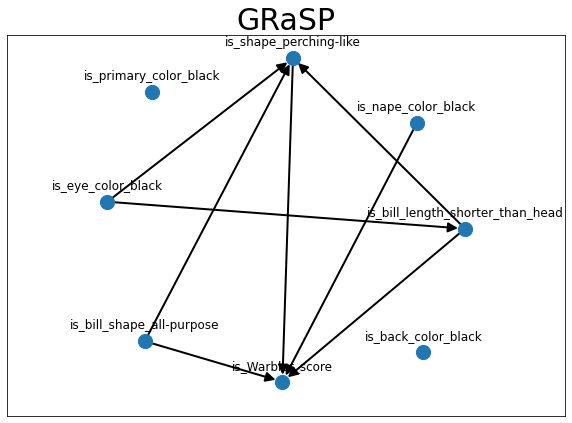

In [36]:
plot_graph(grasp_graph, node_size=200, figsize=(10, 7))
plt.title("GRaSP", fontsize=30)
plt.show()

In [33]:
nx.is_directed_acyclic_graph(grasp_graph)

True

In [34]:
len(grasp_graph.edges)

8

In [86]:
GRASP_GRAPH_PATH = "causal_graphs/CUB_concept_graph_GRaSP.pkl"
write_gpickle(grasp_graph, GRASP_GRAPH_PATH)

# Causal Discovery ICA LiNGAM

In [37]:
ica_lingam_graph = causal_discovery(
    df_train[vars_for_causal_discovery], method="ICALiNGAM", max_iter=1000
)

Doing causal discovery with method: ICALiNGAM.


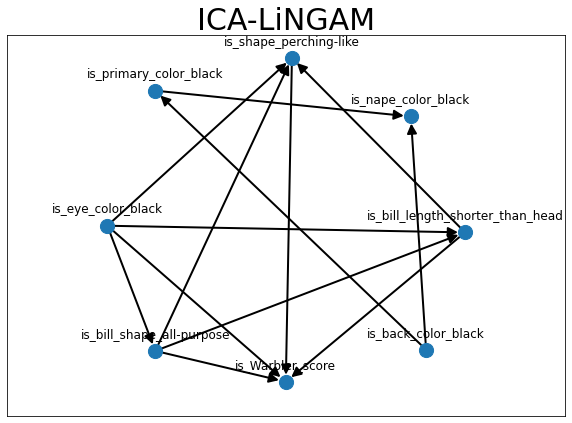

In [43]:
plot_graph(ica_lingam_graph, node_size=200, figsize=(10, 7))
plt.title("ICALiNGAM", fontsize=30)
plt.show()

In [39]:
nx.is_directed_acyclic_graph(ica_lingam_graph)

True

In [40]:
len(ica_lingam_graph.edges)

13

In [97]:
LINGAM_GRAPH_PATH = "causal_graphs/CUB_concept_graph_ICALiNGAM.pkl"
write_gpickle(ica_lingam_graph, LINGAM_GRAPH_PATH)